In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
from astropy.time import Time
from datetime import datetime
from copy import deepcopy
import warnings

from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

warnings.filterwarnings("ignore")

%matplotlib widget

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# plt.rc('font', size=21)
# plt.rc('xtick', labelsize=21)
# plt.rc('ytick', labelsize=21)

fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt*1.5  # 17
fig_height =fig_width*golden_mean # height in inches
fig_size = [fig_width,fig_height] #(9,5.5) #(9, 4.5)
fig_height_full = fig_width_full*golden_mean

fig_size_full = [fig_width_full,fig_height_full] #(9,5.5) #(9, 4.5)

In [3]:
# collated_df = pd.DataFrame(columns = ["MJD", "Observatory", "Filter", "Svo_filter", "Flux", "d_Flux", "Mag", "d_Mag"])

z = 0.019
numerator = (1+z)**2 - 1
denominator = 1 + (1+z)**2

beta = numerator/denominator

time_change = np.sqrt(1-beta**2)

In [4]:
def yyyymmdd_to_mjd(date_string):
    date = datetime.strptime(date_string, '%Y%m%d')
    time = Time(date, format='datetime', scale='utc')

    mjd = time.mjd
    return mjd

def yyyymmdd_to_mjd_adv(date_string):
    # Adjust the format to match the input, including time and 'Z' (UTC)
    date = datetime.strptime(date_string, '%Y%m%dT%H:%M:%SZ')
    time = Time(date, format='datetime', scale='utc')

    mjd = time.mjd
    return mjd

def flux_to_ujy(flux, zp):
    c = (8.9-zp)/2.5
    return flux * 1e6 * 10**c

def flux_to_mag(flux, zp):
    return -2.5 * np.log10(flux) + zp

def flux_to_mag_err(flux, d_flux, zp, d_zp):
    term1 = d_zp**2
    term2 = ( 2.5/(np.log(10)) * (d_flux / flux) )**2
    return np.sqrt(term1 + term2)
    
def ujy_to_flux_err(flux, d_flux, zp, d_zp):
    c = (8.9-zp)/2.5
    term1 = d_flux * 10**c
    term2 = flux * np.log(10) * 10**c * d_zp
    return 1e6*np.sqrt(term1**2 + term2**2)

# '20191117T00:08:28Z'

In [5]:
df = pd.read_csv('../Data/vxm_collated_data.csv')

df['Filter'] = df['Filter'].str.replace(' ', '')

tess_binned_18 = np.load('../Data/tess_binned_lc_18.npy')
tess_binned_21 = np.load('../Data/tess_binned_lc_21.npy')
tess_psf = np.load('../Data/tess_sector_18_psf.npy')

tess_zp_df = pd.read_csv('../Data/tess_zp.csv')

tess_zp = tess_zp_df[(tess_zp_df['Sector'] == 18) & (tess_zp_df['Method'] == 'psf')]

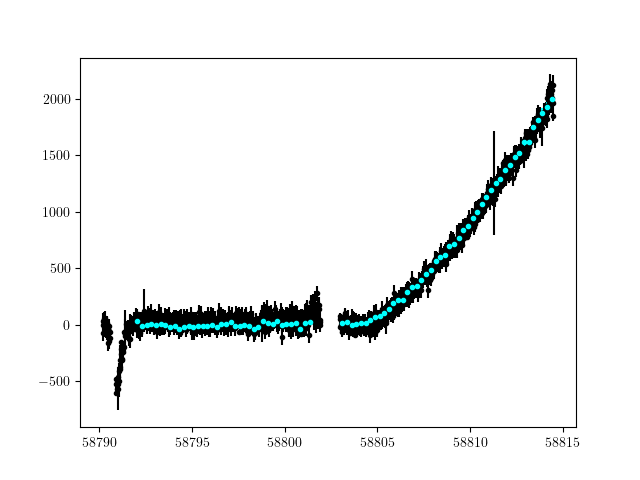

In [6]:
plt.figure()
plt.errorbar(tess_psf[0], flux_to_ujy(tess_psf[1], tess_zp['ZP'].values[0]), 
             yerr=ujy_to_flux_err(tess_psf[1], tess_psf[2], tess_zp['ZP'].values[0], tess_zp['d_ZP'].values[0]), 
             fmt='.', color='k', label='TESS')
plt.errorbar(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], tess_zp['ZP'].values[0]), 
             yerr=ujy_to_flux_err(tess_binned_18[1], tess_binned_18[2], tess_zp['ZP'].values[0], tess_zp['d_ZP'].values[0]), 
             fmt='.', color='cyan', label='TESS')
# plt.errorbar(tess_binned[0], tess_binned[1], yerr=tess_binned[2], fmt='.', color='cyan', label='TESS Binned')
plt.show()

In [7]:
collated_df = pd.DataFrame(columns=df.columns)

indices = np.where((tess_binned_18[0] > 58804.08) & (tess_binned_18[0] < 59500) & 
                   (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) > 0) & 
                   (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) < 20))[0]

In [8]:
collated_df['MJD'] = tess_binned_18[0][indices]
collated_df['Observatory'] = 'TESS'
collated_df['Filter'] = 'R'
collated_df['Svo_filter'] = 'TESS/TESS.Red'
collated_df['Flux'] = flux_to_ujy(tess_binned_18[1], 20.576474800725272)[indices]
collated_df['d_Flux'] = ujy_to_flux_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0])[indices]
collated_df['Mag'] = flux_to_mag(tess_binned_18[1], 20.576474800725272)[indices]
collated_df['d_Mag'] = flux_to_mag_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0])[indices]
collated_df['WavelengthEff'] = 7452.64
collated_df['FrequencyEff'] = 2.99792458e8/7452.64/1e-10

collated_df = pd.concat([collated_df, df], ignore_index = True)

collated_df.to_csv('../Data/collated_vxm_data_with_tess.csv')

In [10]:
unique_combinations = df[['Observatory', 'Filter']].drop_duplicates()

unique_combinations = unique_combinations.reset_index(drop=True)

unique_combinations['Colour'] = None
unique_combinations['Edgecolour'] = 'grey'
unique_combinations['Markersize'] = None
unique_combinations['Linewidth'] = 0.8
unique_combinations['Marker'] = None
unique_combinations['Label'] = None
unique_combinations['b/r'] = None

unique_filters = pd.DataFrame(columns = ['Filter', 'Colour', 'Label', 'b/r'])

unique_filters['Filter'] = np.array(unique_combinations['Filter'].drop_duplicates().reset_index(drop=True).values, dtype = str)
unique_filters['Colour'] = ['darkorange', 'cyan', 'red', 'darkred', 'green', 'rebeccapurple', 'C1', 'steelblue', 
                            'mediumseagreen', 'rebeccapurple', 'magenta', 'darkblue', 'purple', 'darkgreen']
unique_filters['Label'] = '$' + unique_filters['Filter'] + '$'
unique_filters['b/r'] = ['r', 'b', 'r', 'r', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

unique_observatory = pd.DataFrame(columns = ['Observatory', 'Marker', 'Markersize', 'Label'])

unique_observatory['Observatory'] = np.array(unique_combinations['Observatory'].drop_duplicates().reset_index(drop=True).values, dtype = str)
unique_observatory['Marker'] = ['p', 'v', 'h', 'X', 'P', 's', 'd']
unique_observatory['Markersize'] = [90, 60, 55, 70, 60, 42, 90]
unique_observatory['Label'] = unique_observatory['Observatory']
unique_observatory['Label'][unique_observatory['Observatory'] == 'Siding Springs'] = 'Sinistro'

# unique_observatory['Label'][unique_observatory['Label'] == 'TESS'] = '$TESS$'
unique_observatory['Label'][unique_observatory['Label'] == 'Gaia'] = '$Gaia$'
unique_observatory['Label'][unique_observatory['Label'] == 'Swift'] = '$Swift$'

unique_observatory

,Observatory,Marker,Markersize,Label
0,ATLAS,p,90,ATLAS
1,PS1,v,60,PS1
2,Siding Springs,h,55,Sinistro
3,ZTF,X,70,ZTF
4,Swift,P,60,$Swift$
5,Gaia,s,42,$Gaia$
6,Konkoly,d,90,Konkoly


In [11]:
for i in range(len(unique_combinations)):
    unique_combinations['Colour'][i] = unique_filters['Colour'][unique_filters['Filter'] == unique_combinations['Filter'][i]].values[0]
    unique_combinations['Label'][i] = unique_observatory['Label'][unique_observatory['Observatory'] == unique_combinations['Observatory'][i]].values[0] + '-' + unique_filters['Label'][unique_filters['Filter'] == unique_combinations['Filter'][i]].values[0]
    unique_combinations['Marker'][i] = unique_observatory['Marker'][unique_observatory['Observatory'] == unique_combinations['Observatory'][i]].values[0]
    unique_combinations['Markersize'][i] = unique_observatory['Markersize'][unique_observatory['Observatory'] == unique_combinations['Observatory'][i]].values[0]
    unique_combinations['b/r'][i] = unique_filters['b/r'][unique_filters['Filter'] == unique_combinations['Filter'][i]].values[0]

unique_combinations['Alpha'] = 1
unique_combinations['Alpha'][unique_combinations['Observatory'] == 'ATLAS'] = 0.6

# unique_combinations['Edgecolour'][unique_combinations['Observatory'] == 'ATLAS'] = unique_combinations['Colour'][unique_combinations['Observatory'] == 'ATLAS']
# unique_combinations['Linewidth'][unique_combinations['Observatory'] == 'ATLAS'] = 0

In [12]:
unique_combinations

,Observatory,Filter,Colour,Edgecolour,Markersize,Linewidth,Marker,Label,b/r,Alpha
0,ATLAS,o,darkorange,grey,90,0.8,p,ATLAS-$o$,r,0.6
1,ATLAS,c,cyan,grey,90,0.8,p,ATLAS-$c$,b,0.6
2,PS1,i,red,grey,60,0.8,v,PS1-$i$,r,1.0
3,PS1,z,darkred,grey,60,0.8,v,PS1-$z$,r,1.0
4,Siding Springs,g,green,grey,55,0.8,h,Sinistro-$g$,b,1.0
5,Siding Springs,u,rebeccapurple,grey,55,0.8,h,Sinistro-$u$,b,1.0
6,Siding Springs,r,C1,grey,55,0.8,h,Sinistro-$r$,r,1.0
7,Siding Springs,i,red,grey,55,0.8,h,Sinistro-$i$,r,1.0
8,ZTF,g,green,grey,70,0.8,X,ZTF-$g$,b,1.0
9,ZTF,r,C1,grey,70,0.8,X,ZTF-$r$,r,1.0


-0.00040200617283214036


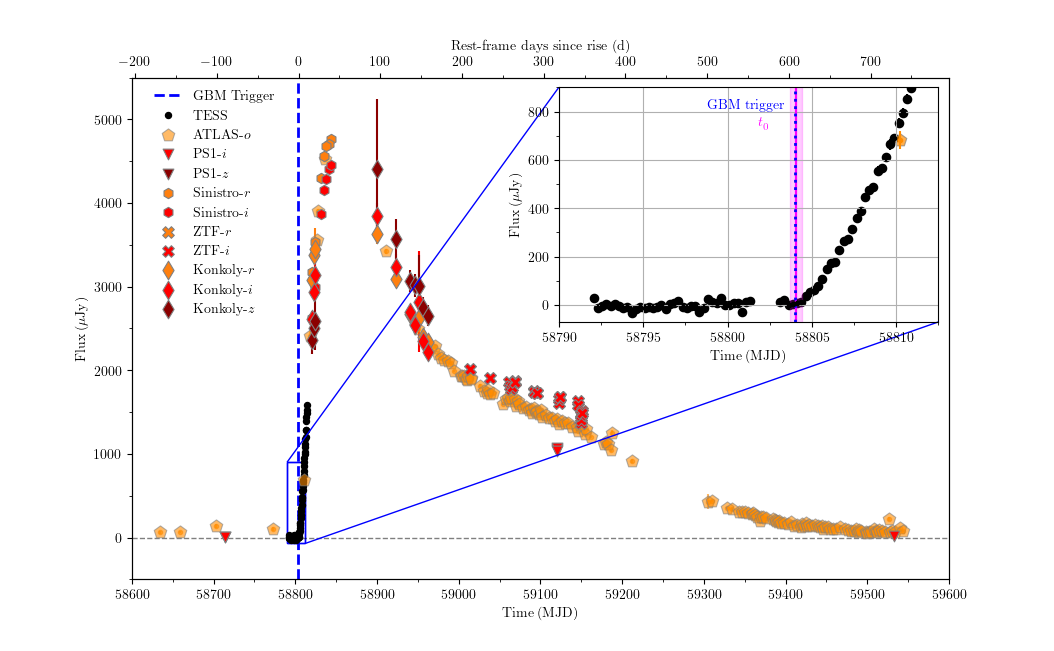

In [28]:
choices = 'r'

fig, axs = plt.subplots(1, 1, figsize = (fig_width_full, fig_height_full))

peak = 58804.03

print((yyyymmdd_to_mjd_adv('20191117T00:08:28Z') - peak) / 60)
peak_space = np.linspace(peak - 0.3, peak + 0.3, 101)

# axs.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 2.2, label = 'Time of First Light')
axs.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = '--', alpha = 1, linewidth = 2, label = r'GBM Trigger')
# axs.fill_between(peak_space, -500, 5500, color = 'm', linestyle = '-', alpha = 0.3, linewidth = 2, label = r'GBM Trigge Uncert.')

# mjd_spec = pd.read_csv('../Data/Spectra_dates.csv')['MJD'].values

# for m in range(len(mjd_spec)):
#     mjd = mjd_spec[m]
#     if m == 0:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1, label = 'Spectra Dates')
#     else:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1)

axs.axhline(0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1)
axs.errorbar(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), 
             ujy_to_flux_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0]),
             fmt='.', color='k')
axs.scatter(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), 
            marker='.', color='k', label='TESS', s = 75, zorder = 10)

# axs.scatter(tess_binned_21[0], 1500*np.ones(len(tess_binned_21[0])), 
#             marker='.', color='k', label='TESS', s = 75, zorder = 10)
            #  yerr=ujy_to_flux_err(tess_binned[1], tess_binned[2], tess_zp['ZP'].values[0], tess_zp['d_ZP'].values[0]), 

for i in range(len(unique_combinations)):
    if unique_combinations['b/r'].iloc[i] == choices:
        
        axs.errorbar(df['MJD'][df['Observatory'] == unique_combinations['Observatory'][i]][df['Filter'] == unique_combinations['Filter'][i]], 
                    df['Flux'][df['Observatory'] == unique_combinations['Observatory'][i]][df['Filter'] == unique_combinations['Filter'][i]], 
                    df['d_Flux'][df['Observatory'] == unique_combinations['Observatory'][i]][df['Filter'] == unique_combinations['Filter'][i]], 
                    color = unique_combinations['Colour'][i],
                    alpha = unique_combinations['Alpha'][i],
                    fmt = '.')
        
        axs.scatter(df['MJD'][df['Observatory'] == unique_combinations['Observatory'][i]][df['Filter'] == unique_combinations['Filter'][i]], 
                    df['Flux'][df['Observatory'] == unique_combinations['Observatory'][i]][df['Filter'] == unique_combinations['Filter'][i]], 
                    color = unique_combinations['Colour'][i], 
                    edgecolor = unique_combinations['Edgecolour'][i], 
                    s = unique_combinations['Markersize'][i], 
                    linewidth = unique_combinations['Linewidth'][i], 
                    label = unique_combinations['Label'][i], 
                    alpha = unique_combinations['Alpha'][i],
                    marker = unique_combinations['Marker'][i], zorder = 20)
        


axs.set_xlim(58600, 59600)
axs.set_ylim(-500, 5500)
axs.yaxis.set_minor_locator(MultipleLocator(500))
axs.yaxis.set_major_locator(MultipleLocator(1000))

axs.xaxis.set_minor_locator(MultipleLocator(50))
axs.xaxis.set_major_locator(MultipleLocator(100))

axs1 = axs.twiny()
axs1.set_xlim(time_change*(58600 - peak), time_change*(59600 - peak))
axs1.set_xlabel(r'Rest-frame days since rise$\;({\rm d})$')

axs1.xaxis.set_minor_locator(MultipleLocator(50))
axs1.xaxis.set_major_locator(MultipleLocator(100))

axs.set_xlabel(r'${\rm Time}\;({\rm MJD})$')
axs.set_ylabel(r'${\rm Flux}\;(\mu{\rm Jy})$')


# axins = fig.add_axes([0.51, 0.49, 0.39, 0.39])  # [left, bottom, width, height] in figure fraction
axins = fig.add_axes([0.53, 0.505, 0.36, 0.36])  # [left, bottom, width, height] in figure fraction

axins.scatter(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), color = 'k', alpha = 1, label = r'TESS $R$', s = 35)
axins.errorbar(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), 
               ujy_to_flux_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0]),
               fmt='.', color='k')

if choices == 'r':
    axins.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], 
                  color='darkorange', s=90, marker='p', alpha = 0.7, edgecolor='grey', linewidth=0.8)
    axins.errorbar(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], 
                   df['d_Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], color='darkorange', fmt='.')
elif choices == 'b':
    axins.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], 
                  color='cyan', edgecolor='grey', s=75, linewidth=0.8, marker='.')

axins.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 1.6, label = 'Explosion time')
axins.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = ':', alpha = 1, linewidth = 2, label = r'GBM Trigger')

axins.fill_betweenx([-250, 5750], 58804.08 - 0.36, 58804.08 + 0.36, color = 'magenta', alpha = 0.2)

axins.text(58798.8, 810, r'GBM trigger', color = 'b',)
axins.text(58801.8, 740, r'$t_{\rm 0}^{}$', color = 'magenta')

axins.set_xlim(58790, 58812.5)
axins.set_ylim(-70, 900)

axins.set_xlabel(r'${\rm Time}\;({\rm MJD})$')
axins.set_ylabel(r'${\rm Flux}\;(\mu{\rm Jy})$')

axins.yaxis.set_minor_locator(MultipleLocator(100))
axins.yaxis.set_major_locator(MultipleLocator(200))

axins.xaxis.set_minor_locator(MultipleLocator(2.5))
axins.xaxis.set_major_locator(MultipleLocator(5))

axins.grid(True)

rect = Rectangle((58790, -70), 22.5, 970, linewidth=1, edgecolor='b', facecolor='none')
axs.add_patch(rect)

mark_inset(axs, axins, loc1=2, loc2=4, fc="none", ec="b")


axs.legend(ncol = 1, bbox_to_anchor=(0.19, 1.0), loc='upper right', frameon=False)
# axs.legend(ncol = 1, bbox_to_anchor=(1.008, 1.015), loc='upper right')
plt.savefig('../Plots/vxm_complete_flux.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()


-0.00040200617283214036


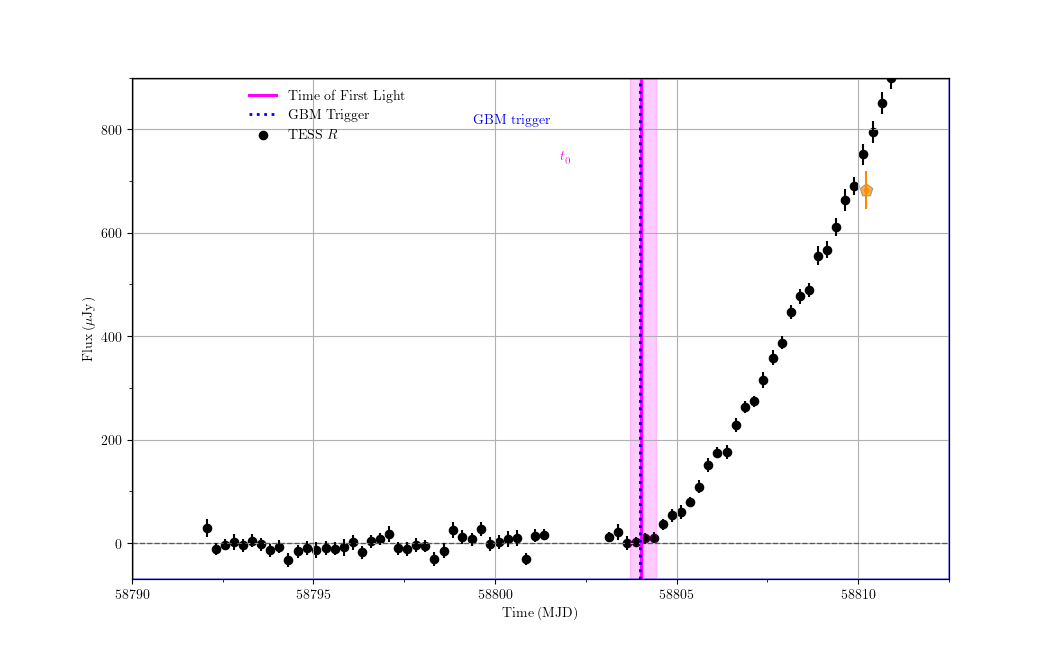

In [18]:
choices = 'r'

fig, axs = plt.subplots(1, 1, figsize = (fig_width_full, fig_height_full))

peak = 58804.03

print((yyyymmdd_to_mjd_adv('20191117T00:08:28Z') - peak) / 60)
peak_space = np.linspace(peak - 0.3, peak + 0.3, 101)

axs.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 2.2, label = 'Time of First Light')
axs.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = ':', alpha = 1, linewidth = 2, label = r'GBM Trigger')
# axs.fill_between(peak_space, -500, 5500, color = 'm', linestyle = '-', alpha = 0.3, linewidth = 2, label = r'GBM Trigge Uncert.')

# mjd_spec = pd.read_csv('../Data/Spectra_dates.csv')['MJD'].values

# for m in range(len(mjd_spec)):
#     mjd = mjd_spec[m]
#     if m == 0:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1, label = 'Spectra Dates')
#     else:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1)

axs.axhline(0, color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1)

# axs.scatter(tess_binned_21[0], 1500*np.ones(len(tess_binned_21[0])), 
#             marker='.', color='k', label='TESS', s = 75, zorder = 10)
            #  yerr=ujy_to_flux_err(tess_binned[1], tess_binned[2], tess_zp['ZP'].values[0], tess_zp['d_ZP'].values[0]),         


# axs.set_xlim(58600, 59600)
# axs.set_ylim(-500, 5500)
# axs.yaxis.set_minor_locator(MultipleLocator(500))
# axs.yaxis.set_major_locator(MultipleLocator(1000))

# axs.xaxis.set_minor_locator(MultipleLocator(50))
# axs.xaxis.set_major_locator(MultipleLocator(100))

axs1 = axs.twiny()
axs1.set_xlim(time_change*(58790 - peak), time_change*(58790 - peak))
# axs1.set_xlabel(r'Rest-frame days since rise$\;({\rm d})$')

axs1.xaxis.set_minor_locator(MultipleLocator(2.5))
axs1.xaxis.set_major_locator(MultipleLocator(5))

axs.scatter(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), color = 'k', alpha = 1, label = r'TESS $R$', s = 35)
axs.errorbar(tess_binned_18[0], flux_to_ujy(tess_binned_18[1], 20.576474800725272), 
               ujy_to_flux_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0]),
               fmt='.', color='k')

axs1.plot([])

if choices == 'r':
    axs.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], 
                  color='darkorange', s=90, marker='p', alpha = 0.7, edgecolor='grey', linewidth=0.8)
    axs.errorbar(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], 
                   df['d_Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], color='darkorange', fmt='.')
elif choices == 'b':
    axs.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], df['Flux'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], 
                  color='cyan', edgecolor='grey', s=75, linewidth=0.8, marker='.')

axs.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 2.2)#, label = 'Explosion time')
axs.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = ':', alpha = 1, linewidth = 2)#, label = r'GBM Trigger')

axs.fill_betweenx([-250, 5750], 58804.08 - 0.36, 58804.08 + 0.36, color = 'magenta', alpha = 0.2)

axs.text(58799.4, 810, r'GBM trigger', color = 'b',)
axs.text(58801.8, 740, r'$t_{\rm 0}^{}$', color = 'magenta')

axs.set_xlim(58790, 58812.5)
axs.set_ylim(-70, 900)

axs.set_xlabel(r'${\rm Time}\;({\rm MJD})$')
axs.set_ylabel(r'${\rm Flux}\;(\mu{\rm Jy})$')

axs.yaxis.set_minor_locator(MultipleLocator(100))
axs.yaxis.set_major_locator(MultipleLocator(200))

axs.xaxis.set_minor_locator(MultipleLocator(2.5))
axs.xaxis.set_major_locator(MultipleLocator(5))

axs.grid(True)

rect = Rectangle((58790, -70), 22.5, 970, linewidth=1, edgecolor='b', facecolor='none')
axs.add_patch(rect)

mark_inset(axs, axins, loc1=2, loc2=4, fc="none", ec="b")

axs.legend(ncol = 1, bbox_to_anchor=(0.35, 1.0), loc='upper right', frameon=False)
# axs.legend(ncol = 1, bbox_to_anchor=(1.008, 1.015), loc='upper right')
# plt.savefig('../Plots/vxm_inset_flux.png', format = 'png', bbox_inches = 'tight', dpi = 600)
plt.show()


In [25]:
(peak - yyyymmdd_to_mjd_adv('20191117T00:08:28Z')) * 24 * 60

34.73333333269693

In [20]:
from astropy.cosmology import FlatLambdaCDM

lcdm = FlatLambdaCDM(H0=70, Om0=0.3)
z = 0.019

d_L = lcdm.luminosity_distance(z).value

mu = 5 * np.log10(d_L) + 25

mu

34.58391177490223

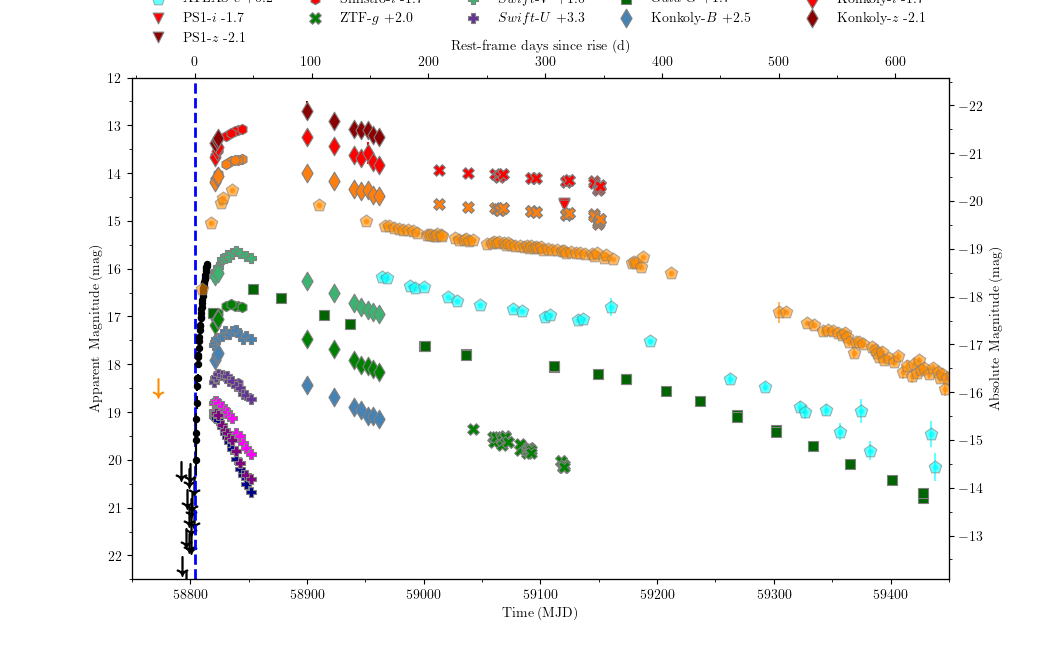

In [23]:
fig, axs = plt.subplots(1, 1, figsize = (fig_width_full, fig_height_full))

peak = 58804.03
peak_space = np.linspace(peak - 0.3, peak + 0.3, 101)

# axs.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 2.2, label = 'Time of First Light')
axs.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = '--', alpha = 1, linewidth = 2, label = r'GBM Trigger')
# axs.fill_between(peak_space, -500, 5500, color = 'm', linestyle = '-', alpha = 0.3, linewidth = 2, label = r'GBM Trigge Uncert.')

# mjd_spec = pd.read_csv('../Data/Spectra_dates.csv')['MJD'].values

# for m in range(len(mjd_spec)):
#     mjd = mjd_spec[m]
#     if m == 0:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1, label = 'Spectra Dates')
#     else:
#         axs.axvline(mjd, color = 'k', linestyle = ':', alpha = 0.5, linewidth = 1)

indices = np.where((tess_binned_18[0] > 58804.03) & (tess_binned_18[0] < 59500) & 
                   (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) > 0) & 
                   (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) < 20))[0]

null_indices = np.where((tess_binned_18[0] < 58804.03) & 
                        (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) > 0) & 
                        (flux_to_mag(tess_binned_18[1], tess_zp['ZP'].values[0]) < 26))[0]

axs.scatter(tess_binned_18[0][null_indices], flux_to_mag(tess_binned_18[1], 20.576474800725272)[null_indices], 
            marker=r'$\downarrow$', color='k', s = 200, zorder = 0)

axs.scatter(tess_binned_18[0][indices], flux_to_mag(tess_binned_18[1], 20.576474800725272)[indices], 
            marker='.', color='k', label='TESS', s = 75, zorder = 10)

axs.errorbar(tess_binned_18[0][indices], flux_to_mag(tess_binned_18[1], 20.576474800725272)[indices], 
             yerr=flux_to_mag_err(tess_binned_18[1], tess_binned_18[2], 20.576474800725272, tess_zp['d_ZP'].values[0])[indices],
             fmt='.', color='k')

for i in range(len(unique_combinations)):
    # if unique_combinations['b/r'].iloc[i] == choices:
        
    mjd = df['MJD'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                    (df['Filter'] == unique_combinations['Filter'][i]) & 
                    (df['Mag'] > 0) & (df['Mag'] < 20) & (df['MJD'] > 58804.08)]
    
    mjd_null = df['MJD'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                         (df['Filter'] == unique_combinations['Filter'][i]) & 
                         (df['Mag'] > 0) & (df['Mag'] < 26) & (df['MJD'] < 58804.08)]
    
    mag = df['Mag'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                    (df['Filter'] == unique_combinations['Filter'][i]) & 
                    (df['Mag'] > 0) & (df['Mag'] < 20) & (df['MJD'] > 58804.08)]
    
    mag_null = df['Mag'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                         (df['Filter'] == unique_combinations['Filter'][i]) & 
                         (df['Mag'] > 0) & (df['Mag'] < 26) & (df['MJD'] < 58804.08)]
    
    mag_err = df['d_Mag'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                          (df['Filter'] == unique_combinations['Filter'][i]) & 
                          (df['Mag'] > 0) & (df['Mag'] < 20) & (df['MJD'] > 58804.08)]
    
    mag_err_null = df['d_Mag'][(df['Observatory'] == unique_combinations['Observatory'][i]) & 
                               (df['Filter'] == unique_combinations['Filter'][i]) & 
                               (df['Mag'] > 0) & (df['Mag'] < 26) & (df['MJD'] < 58804.08)]
    
    if unique_combinations['Filter'][i] == 'r':
        mag -= 1
        mag_null -= 1
        add = "-1.0"
    elif unique_combinations['Filter'][i] == 'i':
        mag -= 1.7
        mag_null -= 1.7
        add = "-1.7"
    elif unique_combinations['Filter'][i] == 'z':
        mag -= 2.1
        mag_null -= 2.1
        add = "-2.1"
    elif unique_combinations['Filter'][i] == 'o':
        mag -= 0.4
        mag_null -= 0.4
        add = "-0.4"
    elif unique_combinations['Filter'][i] == 'c':
        mag += 0.2
        mag_null += 0.2
        add = "+0.2"
    elif unique_combinations['Filter'][i] == 'V':
        mag += 1
        mag_null += 1
        add = "+1.0"
    elif unique_combinations['Filter'][i] == 'G':
        mag += 1.7
        mag_null += 1.7
        add = "+1.7"
    elif unique_combinations['Filter'][i] == 'g':
        mag += 2.0
        mag_null += 2.0
        add = "+2.0"
    elif unique_combinations['Filter'][i] == 'B':
        mag += 2.5
        mag_null += 2.5
        add = "+2.5"
    elif unique_combinations['Filter'][i].lower() == 'u':
        mag += 3.3
        mag_null += 3.3
        add = "+3.3"
    elif 'U' in unique_combinations['Filter'][i]:
        mag += 3.6
        mag_null += 3.6
        add = "+3.6"
    # elif 'UVW1' in unique_combinations['Filter'][i]:
    #     mag += 3.8
    #     add = "+3.8"
    else:
        add = ''
        
    axs.errorbar(mjd, mag, mag_err, fmt='.', color=unique_combinations['Colour'][i], alpha = unique_combinations['Alpha'][i])
    
    axs.scatter(mjd, 
                mag,
                color = unique_combinations['Colour'][i], 
                edgecolor = unique_combinations['Edgecolour'][i], 
                s = unique_combinations['Markersize'][i], 
                linewidth = unique_combinations['Linewidth'][i], 
                label = unique_combinations['Label'][i] + f" {add}", 
                marker = unique_combinations['Marker'][i], 
                alpha = unique_combinations['Alpha'][i],zorder = 20)
    
    axs.scatter(mjd_null, mag_null,
                color = unique_combinations['Colour'][i], 
                s = 200,
                linewidth = unique_combinations['Linewidth'][i],
                marker = r"$\downarrow$", 
                zorder = 20)


axs.set_xlim(58750, 59450)
axs.set_ylim(12, 22.5)
axs.invert_yaxis()
# axs.set_ylim(-500, 5500)
axs.yaxis.set_minor_locator(MultipleLocator(0.5))
axs.yaxis.set_major_locator(MultipleLocator(1))

axs.xaxis.set_minor_locator(MultipleLocator(50))
axs.xaxis.set_major_locator(MultipleLocator(100))

axs1 = axs.twiny()

axs1.set_xlim(time_change*(58750 - peak), time_change*(59450 - peak))
axs1.set_xlabel(r'Rest-frame days since rise$\;({\rm d})$')

axs1.xaxis.set_minor_locator(MultipleLocator(50))
axs1.xaxis.set_major_locator(MultipleLocator(100))

axs.set_xlabel(r'${\rm Time}\;({\rm MJD})$')
axs.set_ylabel(r'${\rm Apparent\;\,Magnitude}\;({\rm mag})$')

axs2 = axs.twinx()
axs2.set_ylim(12 - mu, 22.5 - mu)
axs2.invert_yaxis()
axs2.set_ylabel(r'${\rm Absolute\;\,Magnitude}\;({\rm mag})$')

axs2.yaxis.set_minor_locator(MultipleLocator(0.5))
axs2.yaxis.set_major_locator(MultipleLocator(1))

# # axins = fig.add_axes([0.51, 0.49, 0.39, 0.39])  # [left, bottom, width, height] in figure fraction
# axins = fig.add_axes([0.53, 0.505, 0.36, 0.36])  # [left, bottom, width, height] in figure fraction

# axins.scatter(tess_binned[0], flux_to_ujy(tess_binned[1], tess_zp['ZP'].values[0]), color = 'k', alpha = 1, label = r'TESS $R$', s = 35)

# if choices == 'r':
#     axins.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], df['Mag'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'o'], 
#                   color='darkorange', edgecolor='grey', s=165, linewidth=0.8, marker='*')
# elif choices == 'b':
#     axins.scatter(df['MJD'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], df['Mag'][df['Observatory'] == 'ATLAS'][df['Filter'] == 'c'], 
#                   color='cyan', edgecolor='grey', s=165, linewidth=0.8, marker='*')

# axins.axvline(peak, color = 'magenta', linestyle = '-', alpha = 1, linewidth = 2.2, label = 'Explosion time')
# axins.axvline(yyyymmdd_to_mjd_adv('20191117T00:08:28Z'), color = 'b', linestyle = ':', alpha = 1, linewidth = 2, label = r'GBM Trigger')

# # axins.fill_betweenx([-250, 5750], 58803.06 - 0.59*2, 58803.06 + 0.59*2, color = 'b', alpha = 0.1)

# axins.text(58801.8, 810, r'$t_{\rm exp}^{}$', color = 'b',)
# axins.text(58804.8, 810, r'xray shock', color = 'magenta')

# axins.set_xlim(58790, 58812.5)
# axins.set_ylim(-70, 900)

# axins.set_xlabel(r'${\rm Time}\;({\rm MJD})$')
# axins.set_ylabel(r'${\rm Flux}\;(\mu{\rm Jy})$')

# axins.yaxis.set_minor_locator(MultipleLocator(100))
# axins.yaxis.set_major_locator(MultipleLocator(200))

# axins.xaxis.set_minor_locator(MultipleLocator(2.5))
# axins.xaxis.set_major_locator(MultipleLocator(5))

# axins.grid(True)

# rect = Rectangle((58790, -70), 22.5, 970, linewidth=1, edgecolor='r', facecolor='none')
# axs.add_patch(rect)

# mark_inset(axs, axins, loc1=2, loc2=4, fc="none", ec="r")


axs.legend(ncol = 5, bbox_to_anchor=(1, 1.31), loc='upper right', frameon=False)
# axs.legend(ncol = 1, bbox_to_anchor=(1.008, 1.015), loc='upper right')
plt.savefig('../Plots/magnitude.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()


In [ ]:


df.iloc[df[(df['Filter'] == 'g') & (df['Observatory'] == 'Siding Springs')].Mag.idxmin()]

In [ ]:
temp_df = df[(df['Filter'] == 'UVM2') & (df['Observatory'] == 'Swift')].sort_values('MJD', ascending = True).reset_index(drop = True)

temp_df['tMJD'] = temp_df['MJD'] - 58804.08

peak = temp_df['tMJD'].iloc[temp_df.Mag.idxmin()]
peak_upper = (temp_df['tMJD'].iloc[temp_df.Mag.idxmin() + 1] - temp_df['tMJD'].iloc[temp_df.Mag.idxmin()])/2
peak_lower = (temp_df['tMJD'].iloc[temp_df.Mag.idxmin() - 1] - temp_df['tMJD'].iloc[temp_df.Mag.idxmin()])/2

print(f"${peak:.1f}" + '^{+' + f"{abs(peak_upper):.1f}" + '}_{-' + f"{abs(peak_lower):.1f}" + "}$")

In [ ]:
temp_df

In [ ]:
mjd_spec = pd.read_csv('../Data/Spectra_dates.csv')['MJD'].values
df = pd.read_csv('../Data/vxm_collated_data.csv')



df[abs(df['MJD'] - mjd_spec.min()) < 0.6].Mag.values.mean()


In [ ]:
13.18 - mu

In [ ]:
yyyymmdd_to_mjd_adv('20191117T00:08:28Z')

In [ ]:
58804.031328 - 58804.00587962963


In [ ]:
0.0741203703728388